## Setup

In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt

In [3]:
from thunder.images import fromtif, frombinary
from showit import image

In [4]:
from skimage.io import imsave, imread

In [5]:
from mesoscope.extraction import compare, overlay
from mesoscope.utils import norm

In [6]:
from numpy import round, pi

## Set directory and session information

In [229]:
directory = '/groups/freeman/freemanlab/from_tier2/Nick/neurofinder/neurofinder.02.00'
data = fromtif(directory + '/images', ext='tiff', engine=sc)

In [14]:
def crop(x, a, b):
    x[:,:a] = 0
    x[:,-b:] = 0
    return  x

In [15]:
data = data.map(lambda x: crop(x,31,25))

In [10]:
directory = '/groups/freeman/freemanlab/zaremba_codeneuro_data/03.00'
data = frombinary(directory + '/images', recursive=True, engine=sc, order='F')

In [11]:
data

Images
mode: spark
dtype: int16
shape: (9000, 498, 490)

In [12]:
data = data[:4000,:,:]

In [16]:
mean = data.mean().toarray()

In [17]:
localcorr = data.localcorr(8)

In [18]:
from extraction import load

In [19]:
from extraction import load
modelCompare = load('/groups/freeman/freemanlab/from_tier2/Nick/neurofinder/neurofinder.02.00/regions/regions3.json')
#from json import load
#with open(directory +'/sources/sources.json', 'r') as f:
#    raw = load(f)
#    regions = many([x['coordinates'] for x in raw])
#modelCompare = ExtractionModel(regions)

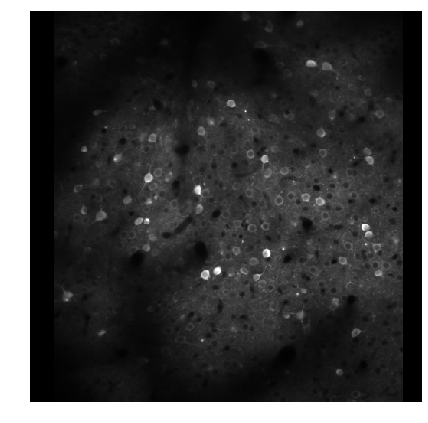

In [20]:
image(mean, clim=(0,600));

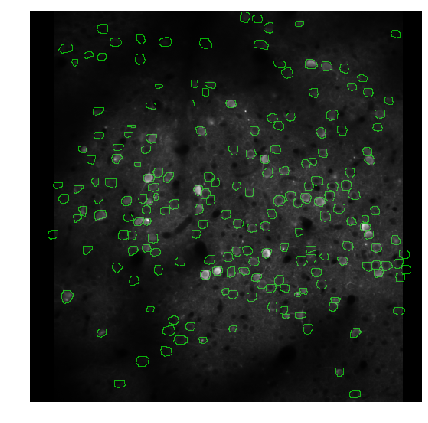

In [21]:
blend = overlay(modelCompare.regions, image=mean)
image(blend);

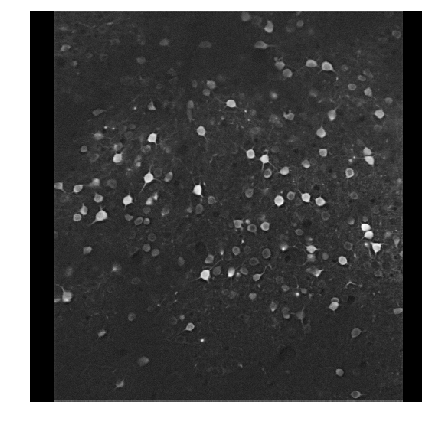

In [22]:
image(localcorr);

/misc/local/python-2.7.11/lib/python2.7/site-packages/skimage/util/dtype.py:110: UserWarning: Possible precision loss when converting from float64 to uint16
  "%s to %s" % (dtypeobj_in, dtypeobj))
/misc/local/python-2.7.11/lib/python2.7/site-packages/skimage/exposure/_adapthist.py:82: skimage_deprecation: `ntiles_*` have been deprecated in favor of `kernel_size`.  The `ntiles_*` keyword arguments will be removed in v0.14
  'will be removed in v0.14', skimage_deprecation)


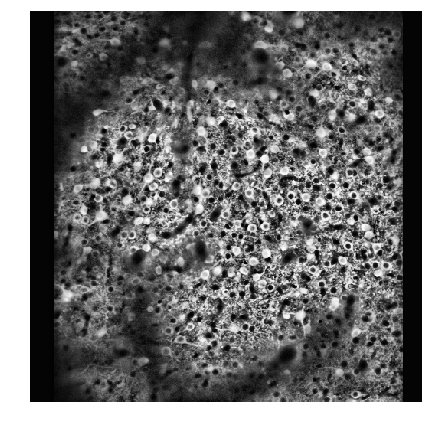

In [23]:
from skimage.exposure import equalize_adapthist
img_adj_mean = equalize_adapthist(norm(mean,10,100), ntiles_x = 32, ntiles_y = 32, clip_limit=0.02, nbins = 1024)
image(img_adj_mean);

### Extraction

In [24]:
from extraction import NMF

In [35]:
algorithm = NMF(k=10, percentile=99, max_iter=50, overlap=0.1)
unmerged = algorithm.fit(data, chunk_size=(50,50), padding=(25,25))
model = unmerged.merge(0.1)

In [36]:
blend = overlay(model.regions, image=mean, compare=modelCompare.regions, threshold=5, correct=True)
compare(model, modelCompare, threshold=5)

{'combined': 0.61072261072261069,
 'count': 232,
 'exclusion': 0.72016566741341026,
 'inclusion': 0.81021828596672341,
 'precision': 0.56465517241379315,
 'recall': 0.6649746192893401,
 'threshold': 5}

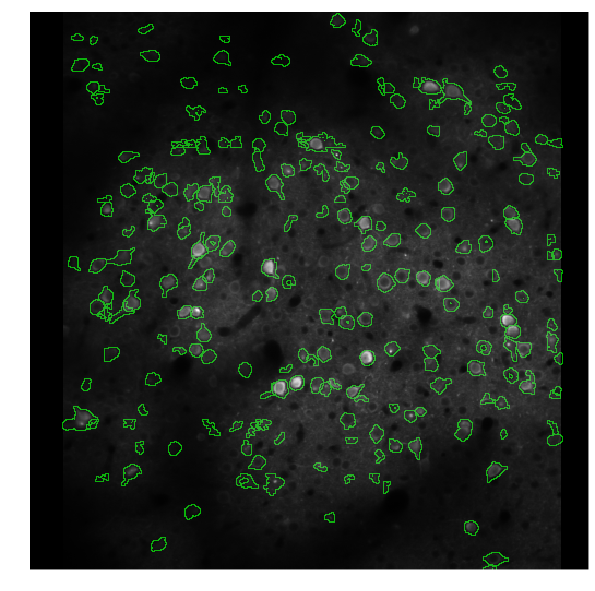

In [37]:
blend = overlay(model.regions, image=mean)
fig = plt.figure(figsize=[10,10])
ax = plt.axes()
image(blend, ax=ax)
plt.xlim([0, blend.shape[1]]);
plt.ylim([blend.shape[0], 0]);

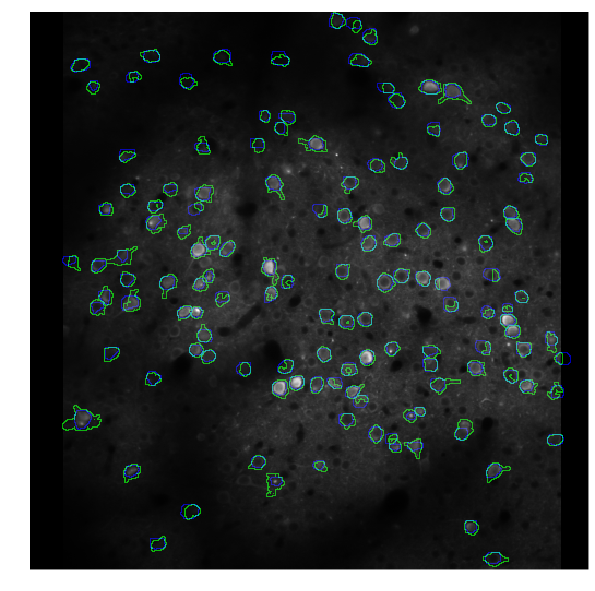

In [28]:
blend = overlay(model.regions, image=mean, compare=modelCompare.regions, threshold=5, correct=True)
fig = plt.figure(figsize=[10,10])
ax = plt.axes()
image(blend, ax=ax)
plt.xlim([0, blend.shape[1]]);
plt.ylim([blend.shape[0], 0]);

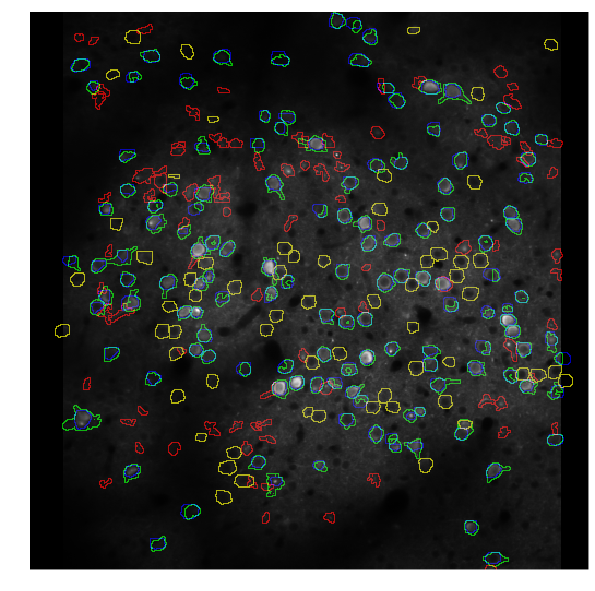

In [29]:
blend = overlay(model.regions, image=mean, compare=modelCompare.regions, threshold=5)
fig = plt.figure(figsize=[10,10])
ax = plt.axes()
image(blend, ax=ax)
plt.xlim([0, blend.shape[1]]);
plt.ylim([blend.shape[0], 0]);

In [978]:
#model.save('/tier2/freeman/Nick/neurofinder/neurofinder.02.00/regions/regions-nmf.json')

## Region morph.

In [91]:
from regional import one
from numpy import zeros, ones

In [92]:
def fill(self):
    """
    Fill a region using morphological operators.
    """
    from scipy.ndimage.morphology import binary_fill_holes
    coords = self.coordinates
    tmp = zeros(self.extent)
    coords = (coords - self.bbox[0:len(self.center)])
    tmp[coords.T.tolist()] = 1
    tmp = binary_fill_holes(tmp)
    new = asarray(where(tmp)).T + self.bbox[0:len(self.center)]
    new = [c for c in new if all(c >= 0)]

    return one(new)

In [93]:
def erosion(self, size):
    """
    Erode a region using morphological operators.
    Parameters
    ----------
    size : int
        Size of erosion in pixels
    """
    if size > 0:
        from scipy.ndimage.morphology import binary_erosion
        size = (size * 2) + 1
        coords = self.coordinates
        tmp = zeros(self.extent + size * 2)
        coords = (coords - self.bbox[0:len(self.center)] + size)
        tmp[coords.T.tolist()] = 1
        tmp = binary_erosion(tmp, ones((size, size)))
        new = asarray(where(tmp)).T + self.bbox[0:len(self.center)] - size
        new = [c for c in new if all(c >= 0)]
    else:
        return self

    return one(new)

In [94]:
def closing(self, size):
    """
    Close a region using morphological operators.
    Parameters
    ----------
    size : int
        Size of closing in pixels
    """
    if size > 0:
        from scipy.ndimage.morphology import binary_closing
        size = (size * 2) + 1
        coords = self.coordinates
        tmp = zeros(self.extent + size * 2)
        coords = (coords - self.bbox[0:len(self.center)] + size)
        tmp[coords.T.tolist()] = 1
        tmp = binary_closing(tmp, ones((size, size)))
        new = asarray(where(tmp)).T + self.bbox[0:len(self.center)] - size
        new = [c for c in new if all(c >= 0)]
    else:
        return self

    return one(new)

In [95]:
def opening(self, size):
    """
    Open a region using morphological operators.
    Parameters
    ----------
    size : int
        Size of opening in pixels
    """
    if size > 0:
        from scipy.ndimage.morphology import binary_opening
        size = (size * 2) + 1
        coords = self.coordinates
        tmp = zeros(self.extent + size * 2)
        coords = (coords - self.bbox[0:len(self.center)] + size)
        tmp[coords.T.tolist()] = 1
        tmp = binary_opening(tmp, ones((size, size)))
        new = asarray(where(tmp)).T + self.bbox[0:len(self.center)] - size
        new = [c for c in new if all(c >= 0)]
    else:
        return self

    return one(new)

In [96]:
def dilate(self, size):
    """
    Dilate a region using morphological operators.
    Parameters
    ----------
    size : int
        Size of dilation in pixels
    """
    if size > 0:
        from scipy.ndimage.morphology import binary_dilation
        size = (size * 2) + 1
        coords = self.coordinates
        tmp = zeros(self.extent + size * 2)
        coords = (coords - self.bbox[0:len(self.center)] + size)
        tmp[coords.T.tolist()] = 1
        tmp = binary_dilation(tmp, ones((size, size)))
        new = asarray(where(tmp)).T + self.bbox[0:len(self.center)] - size
        new = [c for c in new if all(c >= 0)]
    else:
        return self

    return one(new)

## Center detection

In [38]:
from numpy import arange, polyfit, polyval

def detrend(y, order=5):
        """
        Detrend series data with linear or nonlinear detrending.
        Preserve intercept so that subsequent operations can adjust the baseline.
        Parameters
        ----------
        method : str, optional, default = 'linear'
            Detrending method
        order : int, optional, default = 5
            Order of polynomial, for non-linear detrending only
        """

        x = arange(len(y))
        p = polyfit(x, y, order)
        p[-1] = 0
        yy = polyval(p, x)
        return y - yy

In [39]:
from skimage.feature import blob_dog, blob_log, blob_doh

In [40]:
detrended = data.map_as_series(detrend)

In [41]:
meanD = detrended.mean().astype('float32')

In [121]:
localcorrD = detrended.localcorr(11).astype('float32')

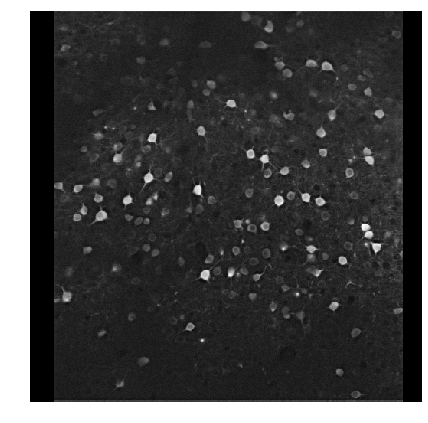

In [122]:
image(localcorrD);

In [361]:
img_adj_lc = norm(equalize_adapthist(localcorr, kernel_size = close_divsor(localcorr.shape[0], 2*11), clip_limit=0.02))

In [362]:
#img_adj_lc[:,:20] = img_adj_lc.mean()
#img_adj_lc[:,-10:] = img_adj_lc.mean()

In [363]:
img_adj_lc[:,:31] = img_adj_lc.mean()
img_adj_lc[:,-25:] = img_adj_lc.mean()

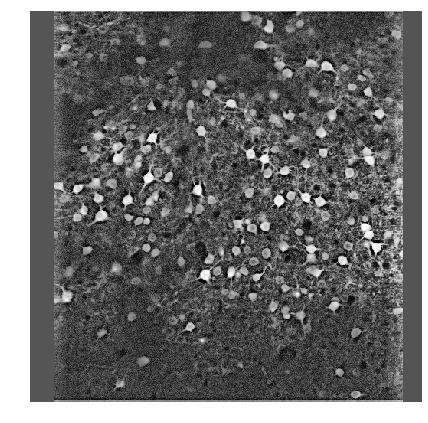

In [364]:
image(img_adj_lc);

In [111]:
diameter = 11

In [127]:
diameter/2.335*2

9.421841541755889

In [200]:
centerLc = blob_log(img_adj_lc, min_sigma=diameter/2.335, max_sigma=diameter/2.335*2, num_sigma=10, threshold=.2)

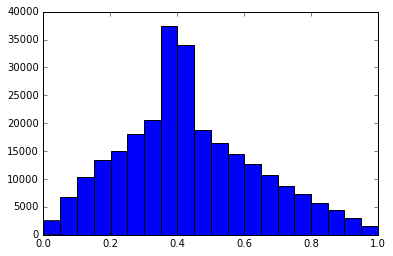

In [201]:
plt.hist(img_adj_lc.flatten(), bins=20);

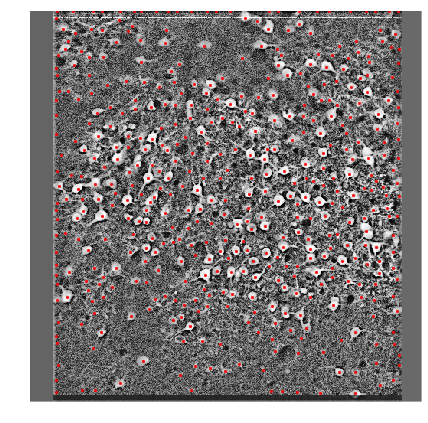

In [210]:
image(img_adj_lc);
plt.plot(centerLc[:,1], centerLc[:,0], 'r.', ms=5);
plt.xlim([0, img_adj_mean.shape[1]]);
plt.ylim([img_adj_mean.shape[0], 0]);

In [236]:
localcorr = data.map_as_series(detrend).localcorr(11)

In [340]:
def close_divsor(n, m):
    n = int(n)
    m = int(m)
    if m > n:
        return n
    
    while n % m:
        m += 1
        
    return m

In [431]:
def centers(image, diameter = 10, clip_limit=0.04, threshold = 0.2):
    """
    Find centers based on local correlation image
    
    
    Parameters
    ----------
    image : thunder images data.
    
    diamter : float, default 10.
        Expected diameter of cells
        
    clip_limit : float, default 0.04.
        Clip limit of adaptive histogram equalization
        
    thershold : float, default 0.2.
        Threshold for blob detection. Decreasing the threshold will detect more blobs
    """
    image = norm(image)
    kernel_size = (close_divsor(image.shape[0], 2*diameter), close_divsor(image.shape[1], 2*diameter))
    image = equalize_adapthist(image, kernel_size=kernel_size, clip_limit=clip_limit)
    image = norm(image)
    coords = blob_log(image, min_sigma=diameter/2.335, max_sigma=diameter/2.335*2, num_sigma=10, threshold=threshold)
    return array([x for x in coords if x[0] > diameter/2 and x[1] > diameter/2 and image.shape[0] - x[0] > diameter/2 and localcorr.shape[1] - x[1] > diameter/2])

In [ ]:
localcorr = data.map_as_series(detrend).localcorr(11)

In [432]:
from numpy import array

In [546]:
centerLc = centers(localcorr[:,30:-30], diameter = 11, clip_limit=0.04, threshold = 0.2)
centerLc = array([[x[0], x[1]+30, x[2]] for x in centerLc])

In [543]:
modelCenter = ExtractionModel([x[:2] for x in centerLc])
compare(modelCenter, modelCompare, threshold = 5)

{'combined': 0.71739130434782605,
 'count': 171,
 'exclusion': 0.97727272727272729,
 'inclusion': 0.011475076662228495,
 'precision': 0.77192982456140347,
 'recall': 0.67005076142131981,
 'threshold': 5}

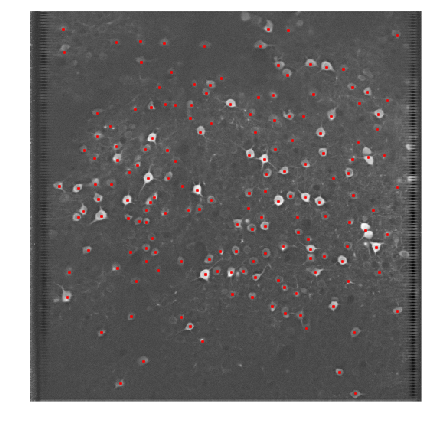

In [547]:
image(localcorr);
plt.plot(centerLc[:,1], centerLc[:,0], 'r.', ms=5);
plt.xlim([0, localcorr.shape[1]]);
plt.ylim([localcorr.shape[0], 0]);

In [548]:
centercoords = [round(region.center).astype('int') for region in modelCenter.regions]

## Center window extraction

In [1001]:
from extraction.model import ExtractionModel

In [1002]:
from numpy import array, pad
    
def select(data, centers, size):
    padded = pad(data, size, 'constant')
    return array([padded[center[0]:center[0]+2*size+1,center[1]:center[1]+2*size+1] for center in centers])

In [1003]:
def selectcenters(data, centers, size):
    return data.map(lambda x: select(x, centers, size), value_shape = (len(centers), 2*size+1, 2*size+1))

In [1004]:
def centercorr(self, sigma=2):
        """
        Correlate every pixel in an image sequence to the average of its local neighborhood.
        This algorithm computes, for every pixel, the correlation coefficient
        between the sequence of values for that pixel, and the average of all pixels
        in a local neighborhood. It does this by blurring the image(s) with a uniform filter,
        and then correlates the original sequence with the blurred sequence.
        Parameters
        ----------
        size : int or tuple, optional, default = 2
            Size of the filter in pixels. If a scalar, will use the same filter size
            along each dimension.
        """

        from thunder.images.readers import fromarray, fromrdd
        from numpy import corrcoef, concatenate, tile, array, isnan
        from scipy.ndimage.filters import gaussian_filter
        
        nimages = self.shape[0]

        # spatially average the original image set over the specified neighborhood
        def restrictedGaussianFilter(x, sigma):
            return array([gaussian_filter(y, sigma) for y in x])
        
        if sigma > 0:
            blurred = self.map(lambda x: restrictedGaussianFilter(x, sigma))
        else:
            blurred = self
        
        def copyCenter(x):
            return tile(x[:, x.shape[1]/2+1, x.shape[2]/2+1], (x.shape[1], x.shape[2], 1)).transpose(2,0,1)

        blurred = blurred.map(copyCenter)
        
        # union the averaged images with the originals to create an
        # Images object containing 2N images (where N is the original number of images),
        # ordered such that the first N images are the averaged ones.
        if self.mode == 'spark':
            combined = self.values.concatenate(blurred.values)
            combined_images = fromrdd(combined.tordd())
        else:
            combined = concatenate((self.values, blurred.values), axis=0)
            combined_images = fromarray(combined)

        # correlate the first N (averaged) records with the last N (original) records
        series = combined_images.toseries().normalize().squelch(.2)
        corr = series.map(lambda x: corrcoef(x[:nimages], x[nimages:])[0, 1]).toarray()
        corr[isnan(corr)] = 0
        
        return corr

In [1005]:
from numpy import arange, newaxis, exp, log

def makeGaussian(size, fwhm = 3, center=None):
    """ Make a square gaussian kernel.
    size is the length of a side of the square
    fwhm is full-width-half-maximum, which
    can be thought of as an effective radius.
    """

    x = arange(0, size, 1, float)
    y = x[:, newaxis]
    
    if center is None:
        x0 = y0 = size // 2
    else:
        x0 = center[0]
        y0 = center[1]
    
    return exp(-4*log(2) * ((x-x0)**2 + (y-y0)**2) / fwhm**2)

In [1006]:
detrended = data.map_as_series(detrend)

In [1048]:
size = int(11*1.2)

In [1049]:
centercoords = [round(region.center).astype('int') for region in modelCompare.regions]

In [1050]:
centercoords = [round(region.center).astype('int') for region in model.regions]
centercoords = concatenate((centercoords, [round(region.center).astype('int') for region in modelCenter.regions]))

In [839]:
centercoords = [round(region.center).astype('int') for region in model.regions]

In [1053]:
centercoords = [round(region.center).astype('int') for region in modelCenter.regions]

In [1012]:
#centercoords = [round(x).astype('int') for x in centerMean]

In [1013]:
#centercoords = (rand(2000, 2)*512).astype(int)

In [1055]:
reshaped = selectcenters(detrended, centercoords, size)

In [1056]:
corr = centercorr(reshaped, sigma=0)

In [1057]:
avg = select(mean, centercoords, size)

In [1058]:
def centerreplace(img):
    img[img.shape[0]/2+1,img.shape[1]/2+1] = (img[img.shape[0]/2+2,img.shape[1]/2+1] + 
                                          img[img.shape[0]/2,img.shape[1]/2+1] +
                                          img[img.shape[0]/2+1,img.shape[1]/2+2] +
                                          img[img.shape[0]/2+1,img.shape[1]/2] )/4
    return img

In [1059]:
corr = array([centerreplace(img) for img in corr])

In [1060]:
#path = '/tier2/freeman/Nick/neurofinder/neurofinder.02.00/results/lc.tif'
#imsave(path, (255*norm(avg)).astype('uint8'), plugin='tifffile')

## Center boundary detection

In [1061]:
from numpy import where, array, asarray
from regional import one

def mask_to_region(mask):
    coordinates = where(mask)
    return closing(one([[coordinates[0][ii], coordinates[1][ii]] for ii in range(len(coordinates[0]))]),1)

In [1062]:
from single_cell_detect import watershed_edge as detect

In [1063]:
def to_polar(image):
    phase_width = int(2 * pi * image.shape[1]/2 * 10)
    return image_cart_to_polar(image, [image.shape[0]/2, image.shape[1]/2], 0, image.shape[1]/2, phase_width=phase_width, zoom_factor=2)

def radial_range(image):
    curve = to_polar(image).mean(axis=1)
    return curve.max()-curve.min()

In [1064]:
def check_shape(mask, min_length, max_length, min_eccentricity):
    props = regionprops(mask.astype('int'))[0]
    return (props.eccentricity > min_eccentricity) and (props.equivalent_diameter > min_length) and (props.equivalent_diameter < max_length)

In [1065]:
def detect_qc(image, threshold, func, min_length, max_length, min_eccentricity):
    if func(image) > threshold:
        mask = detect(image, dilationSize=2, radial=True, filterSize=50)
        if check_shape(mask, min_length, max_length, min_eccentricity):
            return mask
        else:
            return False
    else:
        return False

In [1066]:
from numpy import any

In [1067]:
def classify(stacks, thresholds, func, min_length, max_length, min_eccentricity):
    regions = []
    for ii in range(len(stacks[0])):
        jj = 0
        mask = False
        while (jj < len(stacks)) and not any(mask):
            mask = detect_qc(stacks[jj][ii], thresholds[jj], func, min_length, max_length, min_eccentricity)
            jj = jj+1
        if any(mask):
            regions.append(mask_to_region(mask))
        else:
            regions.append(False)
    return regions
        

In [1068]:
def replacecenters(regions, centers):
    return ExtractionModel([[y + centers[ii] - [size, size] for y in regions[ii].coordinates] for ii in range(len(centers)) if any(regions[ii])])

In [1069]:
from cell_magic_wand import image_cart_to_polar
from numpy import pi

In [1070]:
from skimage.measure import regionprops

In [1071]:
regions = classify([corr, avg], [0.05, 50], radial_range, 7*1.5, 13*1.5, 0.3)

In [1072]:
modelDetect = replacecenters(regions, centercoords)
# make merge only keep region with highest score
modelDetect = modelDetect.merge(overlap=0.20, max_iter=3, k_nearest=10)
compare(modelCompare, modelDetect, threshold=5)

{'combined': 0.49585253456221196,
 'count': 464,
 'exclusion': 0.6329636820906327,
 'inclusion': 0.81311055065143245,
 'precision': 0.57974137931034486,
 'recall': 0.43317230273752011,
 'threshold': 5}

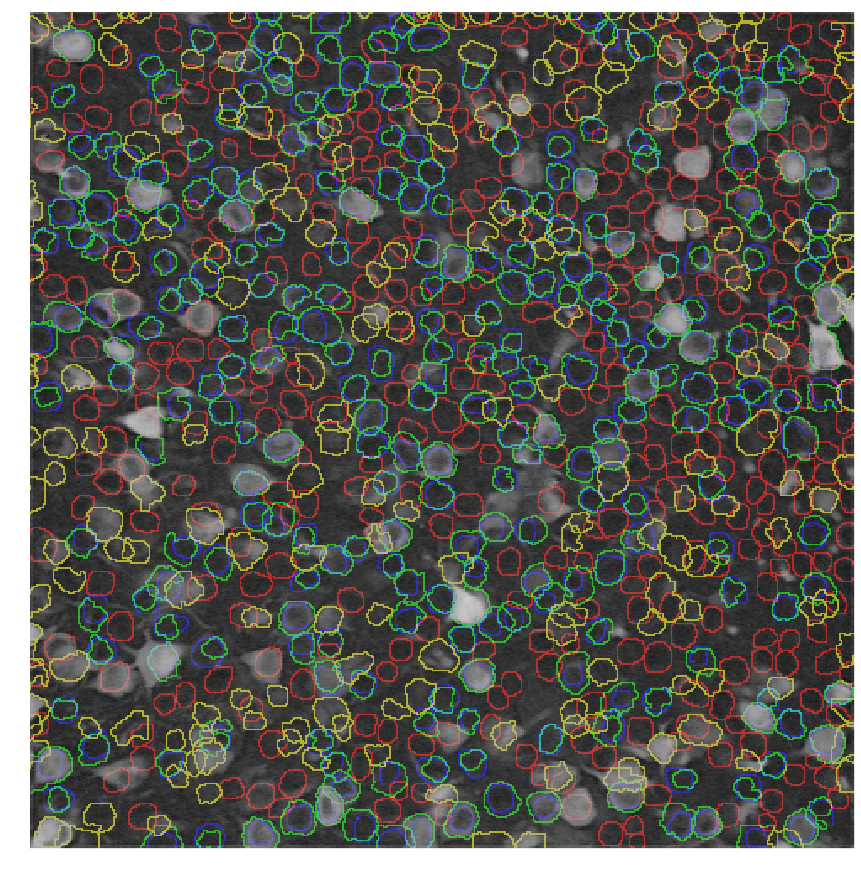

In [1073]:
blend = overlay(modelDetect.regions, image=localcorr, compare=modelCompare.regions, threshold=5, correct=False)
fig = plt.figure(figsize=[15,15])
ax = plt.axes()
image(blend, ax=ax)
plt.xlim([0, blend.shape[1]]);
plt.ylim([blend.shape[0], 0]);

In [1074]:
{'simon': 0.29, 'nick': 0.66, 'packer': 0.39, 'hipp': 0.49, '':}

{'nick': 0.66, 'packer': 0.49, 'simon': 0.29}

In [ ]:
# 1.33 scale factor for packer data

In [ ]:
[[86, 56], [81,61]]

In [403]:
[[72,68],[75,60],[87,57],[86,59]]

[[72, 68], [75, 60], [87, 57], [86, 59]]

In [264]:
compare(modelCompare, modelDetect, threshold=5)

{'exclusion': 0.85891377218933396,
 'inclusion': 0.82557996345501827,
 'precision': 0.7579617834394905,
 'recall': 0.60406091370558379,
 'threshold': 5}

## EXTRAS

In [103]:
from skimage.measure import regionprops
def get_props(regions):
    return [regionprops(region.mask(fill=[1, 1, 1], background=[0, 0, 0])[:,:,0].astype('int')) for region in regions]

In [105]:
props = get_props(modelCompare.regions)

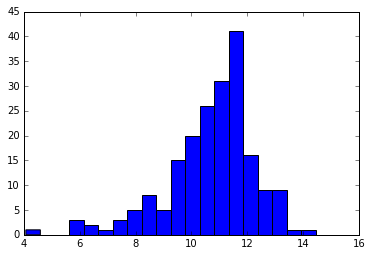

In [106]:
plt.hist([r[0].equivalent_diameter for r in props], bins=20);

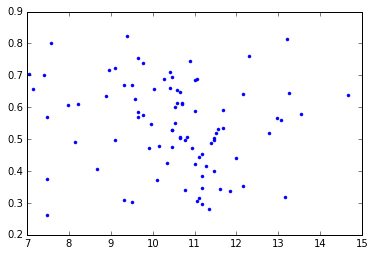

In [389]:
plt.plot([r[0].equivalent_diameter for r in props], [r[0].eccentricity for r in props], '.');

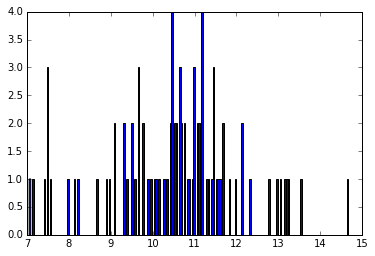

In [390]:
plt.hist([r[0].equivalent_diameter for r in props], bins=200);

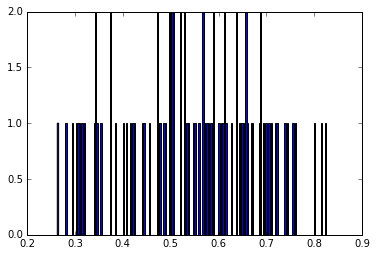

In [391]:
plt.hist([r[0].eccentricity for r in props], bins=200);

In [392]:
shape = array([r[0].eccentricity > 0.2 and r[0].equivalent_diameter > 7 and r[0].equivalent_diameter < 15 for r in props])

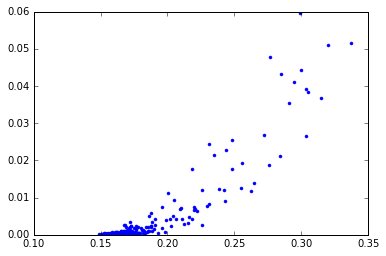

In [393]:
plt.plot([im.mean() for im in norm(stack)], [im.var() for im in norm(stack)], '.');

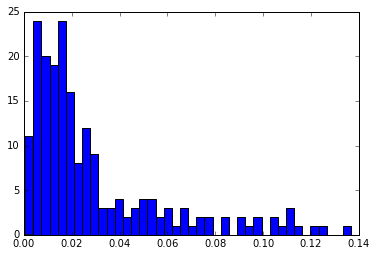

In [394]:
plt.hist([im.mean() for im in stack], bins=40);

In [459]:
def radial_ranges(stack):
    curves = array([to_polar(im).mean(axis=1) for im in stack])
    return array([curve.max()-curve.min() for curve in curves])

In [535]:
maxCorr = radial_ranges(corr)
maxAvg = radial_ranges(avg)
maxAvg_eq = radial_ranges(avg_eq)
maxLc = radial_ranges(lc)

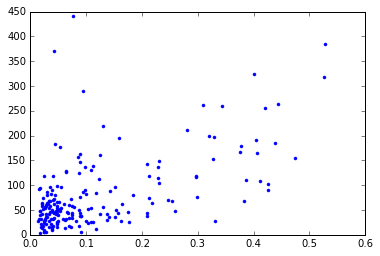

In [468]:
plt.plot(maxCorr, maxAvg, '.')

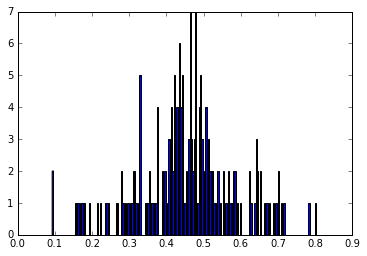

In [471]:
plt.hist(maxAvg_eq, bins=200);
#plt.xlim([0, 0.1])

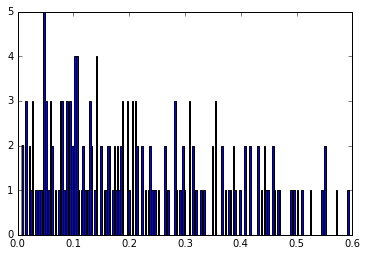

In [536]:
plt.hist(maxLc, bins=200);
#plt.xlim([0, 0.1])

In [88]:
percentile(maxCorr[maxCorr<0.05],99)


0.039769684072662972

In [80]:
maxCorr_threshold = 0.04
maxAvg_threshold = 50

In [70]:
plt.plot(curves.T);

NameError: name 'curves' is not defined

In [71]:
from numpy import sum

In [72]:
sum(maxAvg>0.05)

197

In [73]:
keep = array([norm(stack)[i] for i in range(len(stack)) if max_val[i]>0.05])
reject = array([norm(stack)[i] for i in range(len(stack)) if max_val[i]<=0.05])

NameError: name 'max_val' is not defined

In [320]:
path = '/groups/freeman/freemanlab/from_tier2/Nick/neurofinder/neurofinder.02.00/results/AA-keep.tif'
imsave(path, (255*keep).astype('uint8'), plugin='tifffile')
path = '/groups/freeman/freemanlab/from_tier2/Nick/neurofinder/neurofinder.02.00/results/AA-reject.tif'
imsave(path, (255*reject).astype('uint8'), plugin='tifffile')

In [336]:
keep = ExtractionModel([modelDetect.regions[ii] for ii in range(modelDetect.regions.count) if shape[ii] and (maxCorr[ii]>0.05 or)])

In [398]:
compare(modelCompare, modelDetect,threshold=5)

{'exclusion': 0.89429554962621438,
 'inclusion': 0.82169359784215701,
 'precision': 1.0,
 'recall': 0.4467005076142132,
 'threshold': 5}

## Templates

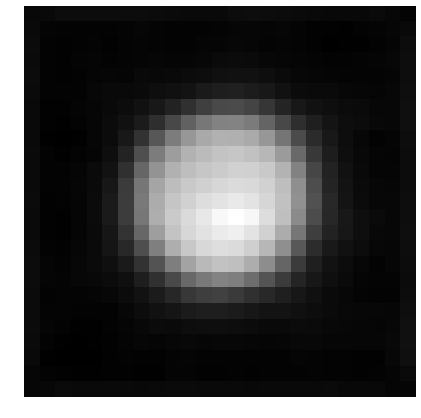

In [1105]:
templateLC = corr.mean(axis=0)
image(templateLC);

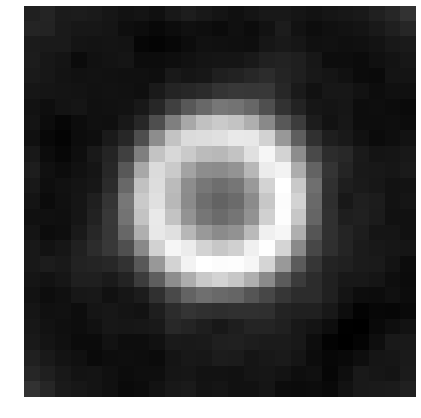

In [1104]:
template = avg.mean(axis=0)
template = template + template.T
image(template);

### Evaluate

In [800]:
def detectcenters(corr, thresh, fwhm=8):
    template = makeGaussian(corr.shape[1], fwhm)
    rescaled = array([x*template for x in corr])
    return [ExtractionModel([array(where(x>thresh)).T]) for x in rescaled]

In [809]:
template = makeGaussian(corr.shape[1], 8)
rescaled = array([x*template for x in corr])*avg

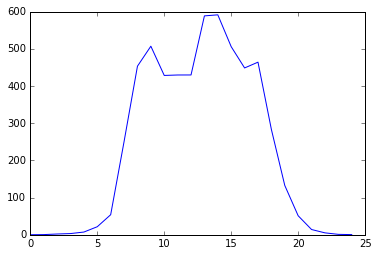

In [810]:
plt.plot(rescaled[0,13,:])

In [817]:
from numpy import linspace
d = []
vals = linspace(50, 300, 50)
for thresh in vals:
    modelList = detectcenters(corr*avg, thresh, fwhm=8)
    modelEmb = replacecenters(modelList, centercoords)
    results = compare(modelEmb, modelCompare, threshold = 5)
    d.append([results['inclusion'], results['exclusion']])
d = array(d)

In [818]:
from numpy import argmax
arg = argmax((d[:,0]**2+d[:,1]**2))
print(d[arg])
print(vals[arg])

[ 0.75844545  0.84235397]
141.836734694


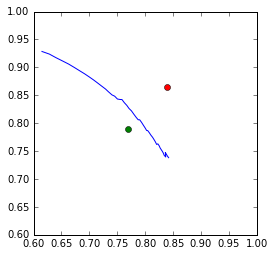

In [819]:
plt.figure(figsize=(4, 4))
plt.plot(d[:,0], d[:,1]);
#plt.plot(dd[:,0], dd[:,1]);

plt.plot(0.77, 0.79, marker='o');
plt.plot(0.839, 0.865, marker='o');

plt.xlim([0.6, 1]);
plt.ylim([0.6, 1]);

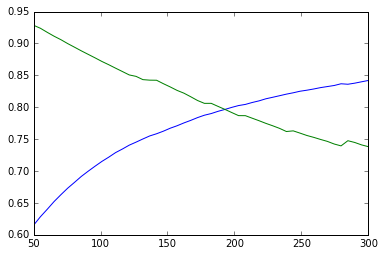

In [820]:
plt.plot(vals, d[:,0]);
plt.plot(vals, d[:,1]);

In [825]:
thresh = 100
modelList = detectcenters(corr*avg, thresh, fwhm=8)
modelEmb = replacecenters(modelList, centercoords)
compare(modelEmb, modelCompare, threshold = 5)

{'exclusion': 0.87304198450671822,
 'inclusion': 0.7134302534049749,
 'precision': 1.0,
 'recall': 1.0,
 'threshold': 5}

In [913]:
compareRegions = [many([array([y - round(x.center).astype('int') + [size+1, size+1] for y in x.coordinates])]) for x in modelCompare.regions]
blend = array([overlay(modelList[i].regions, image=avg[i], compare=compareRegions[i]) for i in range(avg.shape[0])])
#blend = array([overlay(newRegions[i], image=avg[i]) for i in range(avg.shape[0])])

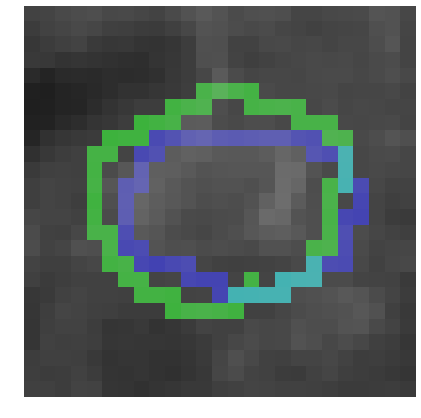

In [917]:
image(blend[16]);

In [66]:
path = '/tier2/freeman/Nick/neurofinder/neurofinder.02.00/results/Qgt-regions-zoom.tif'
imsave(path, (255*blend).astype('uint8'), plugin='tifffile', photometric='rgb')

In [1101]:
from numpy import concatenate
blendL = array([overlay(modelWandList[i].regions, image=avg[i], compare=modelWandListC[i].regions) for i in range(avg.shape[0])])
blendR = array([overlay(modelWandList[i].regions, image=norm(corr,3,99)[i], compare=modelWandListC[i].regions) for i in range(avg.shape[0])])
joined = concatenate((blendL, blendR), axis=2)

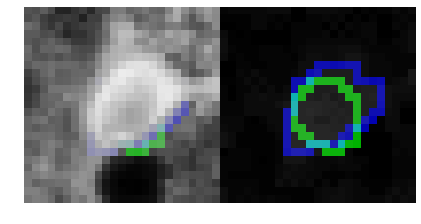

In [1102]:
image(joined[7]);

In [1103]:
path = '/tier2/freeman/Nick/neurofinder/neurofinder.02.00/results/avg_corr_wand3.tif'
imsave(path, (255*joined).astype('uint8'), plugin='tifffile', photometric='rgb')

In [107]:
modelEmbMerged = modelEmb.merge(overlap=0.1, max_iter=2, k_nearest=10)

In [108]:
print(modelEmb.regions.count)
print(modelEmbMerged.regions.count)

242
217


In [113]:
compare(modelEmbMerged, modelCompare, threshold = 5)

{'exclusion': 0.8738154055165005,
 'inclusion': 0.76165465977487201,
 'precision': 0.67005076142131981,
 'recall': 0.60829493087557607,
 'threshold': 5}

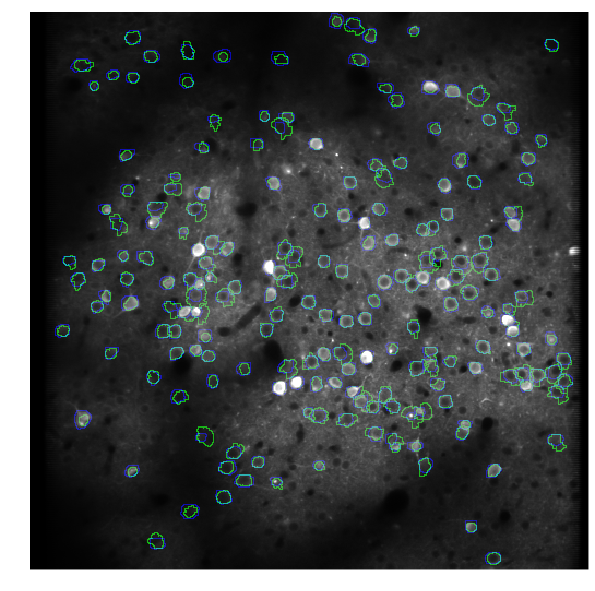

In [871]:
blend = overlay(modelWand.regions, image=mean, compare=modelCompare.regions, threshold=5, correct=False)
fig = plt.figure(figsize=[10,10])
ax = plt.axes()
image(blend, ax=ax)
plt.xlim([0, blend.shape[1]]);
plt.ylim([blend.shape[0], 0]);

In [872]:
path = '/tier2/freeman/Nick/neurofinder/neurofinder.02.00/results/overlay-wand-avg.tif'
imsave(path, (255*blend).astype('uint8'), plugin='tifffile', photometric='rgb')

In [692]:
model.save('/tier2/freeman/Nick/neurofinder/neurofinder.02.00/regions/regions-gtBoundary.json')

## Transform

In [ ]:
sources = model.transform(data)